In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown

## Helper functions

In [14]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

## Purchases Dataset

In [3]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")

amazon_purchases.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_purchases.csv


In [4]:
purchases = pd.read_csv(path)

In [5]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF
...,...,...,...,...,...,...,...,...
1850712,2021-04-01,6.99,1.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1850713,2021-04-14,15.99,1.0,MA,Sinland Microfiber Cleaning Cloth Dish Cloth K...,B00QGCXPRG,TOWEL,R_zfqnsBzlOAKibzb
1850714,2021-05-22,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1850715,2021-12-01,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb


# EDA

# Customers Dataset

In [20]:
path = fetch_dataset("1x737vYSZplHtZdxo99pqB1TGXhcoA6iE", "survey.csv")

survey.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\survey.csv


In [21]:
customers = pd.read_csv(path)
customers

,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
0,R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,heterosexual (straight),Iowa,2,...,No,Yes,No,No,Lost a job,No,No,No,No,No
1,R_2UbJL30HRjK1sdD,45 - 54 years,No,White or Caucasian,High school diploma or GED,"$100,000 - $149,999",Male,heterosexual (straight),Ohio,2,...,No,No,No,No,NaN,No,No,No,No,Yes
2,R_UPXamGKtmf4RVIZ,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),Arkansas,1 (just me!),...,No,No,Yes,No,NaN,No,No,No,No,Yes
3,R_2dYk5auG9Fv5Qve,35 - 44 years,Yes,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$50,000 - $74,999",Male,heterosexual (straight),Tennessee,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,No
4,R_2aP0GyIR66gSTiR,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$50,000 - $74,999",Male,heterosexual (straight),Virginia,2,...,No,Yes,No,No,NaN,No,Yes if consumers get part of the profit,I don't know,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,R_1JLBP1fFf3p8tpy,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$50,000 - $74,999",Male,heterosexual (straight),North Carolina,2,...,Yes,Yes,No,No,NaN,No,No,No,No,Yes
5023,R_Odixb15Ykmxb0Dn,65 and older,No,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$100,000 - $149,999",Female,heterosexual (straight),Michigan,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,Yes
5024,R_2uKaOXO8LfgoFf3,35 - 44 years,No,Black or African American,High school diploma or GED,"Less than $25,000",Male,LGBTQ+,Georgia,1 (just me!),...,No,No,No,No,NaN,No,No,I don't know,No,No
5025,R_2ZZSS68rfn9BMtt,45 - 54 years,No,White or Caucasian,Bachelor's degree,"Less than $25,000",Male,LGBTQ+,Arizona,1 (just me!),...,No,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes


# EDA

# Holidays Dataset

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rohit\.cache\kagglehub\datasets\donnetew\us-holiday-dates-2004-2021\versions\1


In [10]:
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))

In [12]:
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [15]:
holidays

,Date,Holiday,WeekDay,Month,Day,Year,is_holiday
0,2004-07-04,4th of July,Sunday,7,4,2004,True
1,2005-07-04,4th of July,Monday,7,4,2005,True
2,2006-07-04,4th of July,Tuesday,7,4,2006,True
3,2007-07-04,4th of July,Wednesday,7,4,2007,True
4,2008-07-04,4th of July,Friday,7,4,2008,True
...,...,...,...,...,...,...,...
337,2006-04-16,Western Easter,Sunday,4,16,2006,True
338,2017-04-16,Western Easter,Sunday,4,16,2017,True
339,2014-04-20,Western Easter,Sunday,4,20,2014,True
340,2019-04-21,Western Easter,Sunday,4,21,2019,True


# EDA

## Inflation Dataset

In [16]:
path = fetch_dataset("1uuTBlEA2caOIyv4-R_G2OlekBCw-i_Le", "inflation.csv")
inflation_df = pd.read_csv(path)
inflation_df['observation_date'] = pd.to_datetime(inflation_df['observation_date'])
inflation_df = inflation_df.rename(columns={'T10YIEM':'inflation_rate'}).set_index('observation_date')

inflation.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\inflation.csv


In [17]:
inflation_df

,inflation_rate
observation_date,
2018-01-01,2.04
2018-02-01,2.10
2018-03-01,2.09
2018-04-01,2.13
2018-05-01,2.14
2018-06-01,2.12
2018-07-01,2.12
2018-08-01,2.10
2018-09-01,2.12


## EDA

Text(0, 0.5, 'inflation rate')

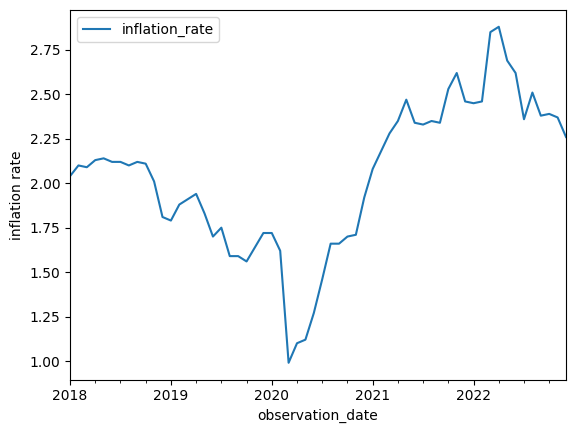

In [23]:
inflation_df.plot()
plt.ylabel('inflation rate')